### Problem Statement

    Identify products at risk of backorder before the event occurs so that business has time to react.

### What is a Backorder?
    Backorders are products that are temporarily out of stock, but a customer is permitted to place an order against future inventory. A backorder generally indicates that customer demand for a product or service exceeds a company’s capacity to supply it. Back orders are both good and bad. Strong demand can drive back orders, but so can suboptimal planning.

### Data

    Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

        sku - Random ID for the product

        national_inv - Current inventory level for the part

        lead_time - Transit time for product (if available)

        in_transit_qty - Amount of product in transit from source

        forecast_3_month - Forecast sales for the next 3 months

        forecast_6_month - Forecast sales for the next 6 months

        forecast_9_month - Forecast sales for the next 9 months

        sales_1_month - Sales quantity for the prior 1 month time period

        sales_3_month - Sales quantity for the prior 3 month time period

        sales_6_month - Sales quantity for the prior 6 month time period

        sales_9_month - Sales quantity for the prior 9 month time period

        min_bank - Minimum recommend amount to stock

        potential_issue - Source issue for part identified

        pieces_past_due - Parts overdue from source

        perf_6_month_avg - Source performance for prior 6 month period

        perf_12_month_avg - Source performance for prior 12 month period

        local_bo_qty - Amount of stock orders overdue

        deck_risk - Part risk flag

        oe_constraint - Part risk flag

        ppap_risk - Part risk flag

        stop_auto_buy - Part risk flag

        rev_stop - Part risk flag

        went_on_backorder - Product actually went on backorder. This is the target value.

#### Identify Right Error Metrics

    Based on the businees, identify right error metrics.

#### Loading the required libraries

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import Callback, LambdaCallback, LearningRateScheduler
from keras.optimizers import SGD
from keras.regularizers import l2

import keras.backend as K

from math import pi, cos, floor, isnan

import matplotlib.pyplot as plt
%matplotlib inline  

Using TensorFlow backend.


#### Loading the data

In [2]:
PATH = os.getcwd()

In [3]:
os.chdir(PATH)

In [4]:
data = pd.read_csv("BackOrders.csv", header=0)

#### Understand the Data

See the number row and columns

In [5]:
data.shape

(61589, 23)

Display the columns

In [6]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

Display the index

In [7]:
data.index

RangeIndex(start=0, stop=61589, step=1)

See the top rows of the data

In [8]:
data.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No


Shows a quick statistic summary of your data using describe.

    For object data (e.g. strings or timestamps), the result’s index will include count, unique, top, and freq. 

    The top is the most common value.

    The freq is the most common value’s frequency.

In [9]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


Display data type of each variable

In [10]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Observations

    sku is Categorical but is interpreted as int64 
    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are also 
    categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [11]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [12]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

##### Delete sku attribute

In [13]:
np.size(np.unique(data.sku))

61589

In [14]:
data.drop('sku', axis=1, inplace=True)

#### Missing Data

    Missing value analysis and dropping the records with missing values

In [15]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

Observing the number of records before and after missing value records removal

In [16]:
print (data.shape)

(61589, 22)


Observation: 

    Since the number of missing values is about 5%. For initial analysis we ignore all these records

In [17]:
data = data.dropna(axis=0)

In [18]:
print(data.isnull().sum())
print("-----------------------")
print(data.shape)

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64
-----------------------
(58186, 22)


#### Converting Categorical to Numeric

    For some of the models all the independent attribute should be of type numeric and ANN model is one among them. But this data set has some categorial attributes.

    Use 'pandas.get_dummies' To convert convert categorical variable into dummy/indicator variables


In [19]:
print (data.columns)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')


##### Creating dummy variables.

    If we have k levels in a category, then we create k-1 dummy variables as the last one would be redundant. So we use the parameter drop_first in pd.get_dummies function that drops the first level in each of the category


In [20]:
categorical_Attributes = data.select_dtypes(include=['category']).columns

In [21]:
for categorical_Attribute in categorical_Attributes:
    print("{} has: {} levels".format(categorical_Attribute, np.size(np.unique(data[categorical_Attribute]))))    

potential_issue has: 2 levels
deck_risk has: 2 levels
oe_constraint has: 2 levels
ppap_risk has: 2 levels
stop_auto_buy has: 2 levels
rev_stop has: 2 levels
went_on_backorder has: 2 levels


In [22]:
data = pd.get_dummies(columns=categorical_Attributes, data=data, prefix=categorical_Attributes, prefix_sep="_",drop_first=True)

In [23]:
print (data.columns, data.shape)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes', 'went_on_backorder_Yes'],
      dtype='object') (58186, 22)


#### Target attribute distribution

In [24]:
pd.value_counts(data['went_on_backorder_Yes'])

0    47217
1    10969
Name: went_on_backorder_Yes, dtype: int64

In [25]:
pd.value_counts(data['went_on_backorder_Yes'])/data['went_on_backorder_Yes'].count() * 100

0    81.148386
1    18.851614
Name: went_on_backorder_Yes, dtype: float64

#### Train-Test Split

Using sklearn.model_selection.train_test_split

    Split arrays or matrices into train and test subsets

In [26]:
X, y = data.loc[:,data.columns!='went_on_backorder_Yes'].values, data.loc[:,'went_on_backorder_Yes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify = data['went_on_backorder_Yes'])

To get the distribution in the target in train and test

In [27]:
print(pd.value_counts(y_train)/y_train.size * 100)
print(pd.value_counts(y_test)/y_test.size * 100)

0    81.14903
1    18.85097
dtype: float64
0    81.146884
1    18.853116
dtype: float64


In [28]:
print(X_train.shape)
print(X_test.shape)

(40730, 21)
(17456, 21)


In [29]:
N_EPOCHS   = 500
EPOCH_SIZE = X_train.shape[0]
BATCH_SIZE = 128
N_STEPS    = np.ceil(EPOCH_SIZE/BATCH_SIZE)

### Build MLP Model

In [30]:
def create_model():
    # Create model
    model = Sequential()

    model.add(Dense(25, input_dim=21, activation='relu', kernel_regularizer=l2(1e-06), kernel_initializer="glorot_normal"))
    model.add(Dropout(0.5))
    model.add(Dense(15, activation='relu', kernel_regularizer=l2(1e-06), kernel_initializer="glorot_normal"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-06), kernel_initializer="glorot_normal"))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [31]:
model = create_model()

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                550       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                390       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [33]:
model_history = model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/500
40730/40730 [==============================] - 2s 46us/step - loss: 1.8532 - acc: 0.7355
Epoch 2/500
40730/40730 [==============================] - 1s 30us/step - loss: 0.8868 - acc: 0.8009
Epoch 3/500
40730/40730 [==============================] - 1s 29us/step - loss: 0.5874 - acc: 0.8087
Epoch 4/500
40730/40730 [==============================] - 1s 33us/step - loss: 0.4831 - acc: 0.8136
Epoch 5/500
40730/40730 [==============================] - 1s 33us/step - loss: 0.4409 - acc: 0.8123
Epoch 6/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.4375 - acc: 0.8120
Epoch 7/500
40730/40730 [==============================] - 1s 25us/step - loss: 0.4112 - acc: 0.8129
Epoch 8/500
40730/40730 [==============================] - 1s 24us/step - loss: 0.3970 - acc: 0.8135
Epoch 9/500
40730/40730 [==============================] - 1s 24us/step - loss: 0.3932 - acc: 0.8181
Epoch 10/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.3834 - a

40730/40730 [==============================] - 1s 26us/step - loss: 0.2744 - acc: 0.8930
Epoch 82/500
40730/40730 [==============================] - 1s 26us/step - loss: 0.2749 - acc: 0.8925
Epoch 83/500
40730/40730 [==============================] - 1s 25us/step - loss: 0.2716 - acc: 0.8941
Epoch 84/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2708 - acc: 0.8918
Epoch 85/500
40730/40730 [==============================] - 1s 26us/step - loss: 0.2746 - acc: 0.8908
Epoch 86/500
40730/40730 [==============================] - 1s 27us/step - loss: 0.2719 - acc: 0.8926
Epoch 87/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2720 - acc: 0.8920
Epoch 88/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2708 - acc: 0.8912
Epoch 89/500
40730/40730 [==============================] - 1s 26us/step - loss: 0.2726 - acc: 0.8932
Epoch 90/500
40730/40730 [==============================] - 1s 27us/step - loss: 0.2736 - acc: 

40730/40730 [==============================] - 1s 23us/step - loss: 0.2679 - acc: 0.8948
Epoch 161/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2643 - acc: 0.8958
Epoch 162/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2689 - acc: 0.8938
Epoch 163/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2728 - acc: 0.8904
Epoch 164/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2689 - acc: 0.8932
Epoch 165/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2710 - acc: 0.8907
Epoch 166/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2706 - acc: 0.8913
Epoch 167/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2651 - acc: 0.8932
Epoch 168/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2685 - acc: 0.8924
Epoch 169/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.265

40730/40730 [==============================] - 1s 22us/step - loss: 0.2615 - acc: 0.8972
Epoch 240/500
40730/40730 [==============================] - 1s 22us/step - loss: 0.2640 - acc: 0.8954
Epoch 241/500
40730/40730 [==============================] - 1s 22us/step - loss: 0.2639 - acc: 0.8962
Epoch 242/500
40730/40730 [==============================] - 1s 22us/step - loss: 0.2642 - acc: 0.8960
Epoch 243/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.2655 - acc: 0.8955
Epoch 244/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.2650 - acc: 0.8955
Epoch 245/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.2636 - acc: 0.8958
Epoch 246/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.2668 - acc: 0.8949
Epoch 247/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.2625 - acc: 0.8970
Epoch 248/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.265

40730/40730 [==============================] - 1s 23us/step - loss: 0.2615 - acc: 0.8971
Epoch 319/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2633 - acc: 0.8965
Epoch 320/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2619 - acc: 0.8970
Epoch 321/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2654 - acc: 0.8955
Epoch 322/500
40730/40730 [==============================] - 1s 24us/step - loss: 0.2636 - acc: 0.8962: 0s - loss: 0.2651 -
Epoch 323/500
40730/40730 [==============================] - 1s 25us/step - loss: 0.2633 - acc: 0.8956
Epoch 324/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2654 - acc: 0.8955
Epoch 325/500
40730/40730 [==============================] - 1s 24us/step - loss: 0.2684 - acc: 0.8934
Epoch 326/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2637 - acc: 0.8959
Epoch 327/500
40730/40730 [==============================] - 1s 22

40730/40730 [==============================] - 1s 23us/step - loss: 0.2604 - acc: 0.8966
Epoch 398/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2665 - acc: 0.8949
Epoch 399/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2622 - acc: 0.8963
Epoch 400/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2615 - acc: 0.8979
Epoch 401/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2641 - acc: 0.8953
Epoch 402/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.2616 - acc: 0.8960
Epoch 403/500
40730/40730 [==============================] - 1s 24us/step - loss: 0.2632 - acc: 0.8943
Epoch 404/500
40730/40730 [==============================] - 1s 24us/step - loss: 0.2625 - acc: 0.8950
Epoch 405/500
40730/40730 [==============================] - 1s 25us/step - loss: 0.2611 - acc: 0.8960
Epoch 406/500
40730/40730 [==============================] - 1s 24us/step - loss: 0.262

40730/40730 [==============================] - 1s 28us/step - loss: 0.2657 - acc: 0.8952
Epoch 477/500
40730/40730 [==============================] - 1s 30us/step - loss: 0.2616 - acc: 0.8961
Epoch 478/500
40730/40730 [==============================] - 1s 29us/step - loss: 0.2649 - acc: 0.8960
Epoch 479/500
40730/40730 [==============================] - 1s 24us/step - loss: 0.2588 - acc: 0.8966
Epoch 480/500
40730/40730 [==============================] - 1s 27us/step - loss: 0.2627 - acc: 0.8960
Epoch 481/500
40730/40730 [==============================] - 1s 31us/step - loss: 0.2634 - acc: 0.8954
Epoch 482/500
40730/40730 [==============================] - 1s 26us/step - loss: 0.2612 - acc: 0.8966
Epoch 483/500
40730/40730 [==============================] - 1s 29us/step - loss: 0.2633 - acc: 0.8965
Epoch 484/500
40730/40730 [==============================] - 1s 27us/step - loss: 0.2595 - acc: 0.8965
Epoch 485/500
40730/40730 [==============================] - 1s 28us/step - loss: 0.261

#### Plot

In [34]:
print(model_history.history.keys())

dict_keys(['loss', 'acc'])


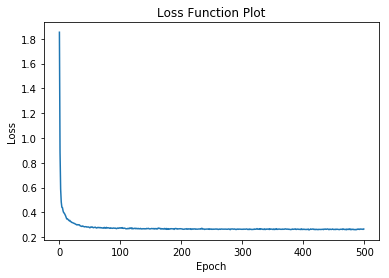

In [35]:
plt.plot(model_history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

#### Predictions on train data

In [36]:
train_pred = model.predict_classes(X_train)
train_pred_prob = model.predict(X_train)

##### Confusion matrix on train data

In [37]:
confusion_matrix_train = confusion_matrix(y_train, train_pred)
print(confusion_matrix_train)

[[31829  1223]
 [ 2523  5155]]


#### Predictions on test data

In [38]:
test_pred = model.predict_classes(X_test)
test_pred_prob = model.predict(X_test)

#### Confusion matrix on test data

In [39]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
print(confusion_matrix_test)

[[13590   575]
 [ 1103  2188]]


##### Accuracy, True Negative Rate and True Positive Rate on both train and test

In [40]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR     : ",TNR_Train)
print("Train TPR     : ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

print('------------------------------------')
Accuracy_Test = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
TPR_Test = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test TNR      : ",TNR_Test)
print("Test TPR      : ",TPR_Test)
print("Test Accuracy : ",Accuracy_Test)

Train TNR     :  0.9629977005930049
Train TPR     :  0.6713988017712946
Train Accuracy:  0.9080284802356985
------------------------------------
Test TNR      :  0.9594069890575362
Test TPR      :  0.6648435126101488
Test Accuracy :  0.9038725939505041


#### Custom callback in Keras.

    This allows the parameters of the schedule to be specified and for the learning rate to be logged so we can ensure it had the desired effect.

    A custom callback can be defined as a Python class that extends the Keras Callback class.

    In the class constructor, we can take the required configuration as arguments and save them for use, specifically the total number of training epochs, the number of cycles for the learning rate schedule, and the maximum learning rate.

### Finding right Learning Rate Range

Note: 
    
    Code is taken from https://gist.github.com/jeremyjordan/ac0229abd4b2b7000aca1643e88e0f02#file-lr_finder-py

In [41]:
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.frac = (self.max_lr-self.min_lr)/self.total_iterations
        self.iteration = 0
        self.history = {}
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        cur_lr = K.get_value(self.model.optimizer.lr)
        
        if cur_lr < self.max_lr:
            cur_lr = cur_lr + self.frac
              
        self.history.setdefault('lr', []).append(cur_lr)
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
                
        K.set_value(self.model.optimizer.lr, cur_lr)

    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()
        
    def plot_loss_change(self, sma=1):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
        """
        assert sma >= 1

        derivative = pd.rolling_mean(self.history['loss'], sma)
            
        plt.plot(self.history['lr'], derivatives)
        plt.ylabel("Loss")
        plt.xlabel("Learning rate")
        plt.xscale('log')
        plt.show()        

In [42]:
model = create_model()

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 25)                550       
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 15)                390       
_________________________________________________________________
dropout_4 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [44]:
n_epochs = 2

lr_finder = LRFinder(min_lr=1e-4, max_lr=1, steps_per_epoch=N_STEPS, epochs=n_epochs)

model.fit(X_train, y_train, callbacks=[lr_finder], epochs=n_epochs)

Epoch 1/2
40730/40730 [==============================] - 4s 102us/step - loss: 1.9116 - acc: 0.8070
Epoch 2/2
40730/40730 [==============================] - 3s 83us/step - loss: 2.7160 - acc: 0.7783


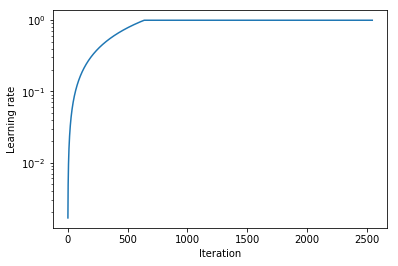

In [45]:
lr_finder.plot_lr()

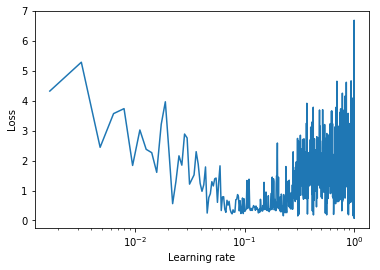

In [46]:
lr_finder.plot_loss()

Observation: 

    From the curve good Learning Rate Range can be between 0.001 to 0.5   

In [48]:
LR_MIN = 0.001
LR_MAX = 0.1

#### Step Decay Scheduler

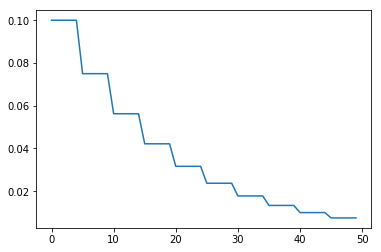

In [50]:
def step_decay_schedule(epoch, initial_lr=1e-3, decay_factor=0.75, step_size=10):

    return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    

n_epochs = 50   
lr_sched = [step_decay_schedule(epoch, initial_lr=LR_MAX, decay_factor=.75, step_size=5) 
            for epoch in range(n_epochs)]

# plot series
plt.plot(lr_sched)
plt.show()

#### LearningRateScheduler

keras.callbacks.LearningRateScheduler(schedule, verbose=0)

    schedule: a function that takes an epoch index as input (integer, indexed from 0) and current learning rate and returns a new learning rate as output (float).
    verbose: int. 0: quiet, 1: update messages.


In [51]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=LR_MAX, decay_factor=0.75, step_size=5)

In [52]:
lr_sched

In [53]:
model = create_model()

In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 25)                550       
_________________________________________________________________
dropout_5 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 15)                390       
_________________________________________________________________
dropout_6 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [55]:
model_history = model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[lr_sched])

Epoch 1/500
40730/40730 [==============================] - 2s 43us/step - loss: 0.5193 - acc: 0.8083
Epoch 2/500
40730/40730 [==============================] - 1s 25us/step - loss: 0.4567 - acc: 0.8114
Epoch 3/500
40730/40730 [==============================] - 1s 24us/step - loss: 0.4545 - acc: 0.8115
Epoch 4/500
40730/40730 [==============================] - 1s 25us/step - loss: 0.4545 - acc: 0.8113
Epoch 5/500
40730/40730 [==============================] - 1s 25us/step - loss: 0.4435 - acc: 0.8115
Epoch 6/500
40730/40730 [==============================] - 1s 26us/step - loss: 0.4428 - acc: 0.8114
Epoch 7/500
40730/40730 [==============================] - 1s 23us/step - loss: 0.4561 - acc: 0.8114
Epoch 8/500
40730/40730 [==============================] - 1s 24us/step - loss: 0.4648 - acc: 0.8113
Epoch 9/500
40730/40730 [==============================] - 1s 24us/step - loss: 0.4722 - acc: 0.8115
Epoch 10/500
40730/40730 [==============================] - 1s 24us/step - loss: 0.6211 - a

40730/40730 [==============================] - 1s 21us/step - loss: 0.3968 - acc: 0.8114
Epoch 82/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.3975 - acc: 0.8114
Epoch 83/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.4001 - acc: 0.8115
Epoch 84/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.3944 - acc: 0.8115
Epoch 85/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.3931 - acc: 0.8115
Epoch 86/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.3941 - acc: 0.8115
Epoch 87/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.3920 - acc: 0.8114
Epoch 88/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.3922 - acc: 0.8114
Epoch 89/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.3909 - acc: 0.8114
Epoch 90/500
40730/40730 [==============================] - 1s 21us/step - loss: 0.3897 - acc: 

40730/40730 [==============================] - 2s 42us/step - loss: 0.3756 - acc: 0.8115
Epoch 161/500
40730/40730 [==============================] - 2s 40us/step - loss: 0.3746 - acc: 0.8115
Epoch 162/500
40730/40730 [==============================] - 2s 40us/step - loss: 0.3760 - acc: 0.8115
Epoch 163/500
40730/40730 [==============================] - 2s 41us/step - loss: 0.3740 - acc: 0.8115
Epoch 164/500
40730/40730 [==============================] - 2s 42us/step - loss: 0.3769 - acc: 0.8115
Epoch 165/500
40730/40730 [==============================] - 2s 42us/step - loss: 0.3765 - acc: 0.8115
Epoch 166/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.3767 - acc: 0.8115
Epoch 167/500
40730/40730 [==============================] - 2s 45us/step - loss: 0.3735 - acc: 0.8115
Epoch 168/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.3768 - acc: 0.8115
Epoch 169/500
40730/40730 [==============================] - 2s 54us/step - loss: 0.375

40730/40730 [==============================] - 2s 45us/step - loss: 0.3741 - acc: 0.8115
Epoch 240/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.3731 - acc: 0.8115
Epoch 241/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.3742 - acc: 0.8115
Epoch 242/500
40730/40730 [==============================] - 2s 43us/step - loss: 0.3727 - acc: 0.8115
Epoch 243/500
40730/40730 [==============================] - 2s 43us/step - loss: 0.3774 - acc: 0.8115
Epoch 244/500
40730/40730 [==============================] - 2s 43us/step - loss: 0.3751 - acc: 0.8115
Epoch 245/500
40730/40730 [==============================] - 2s 41us/step - loss: 0.3741 - acc: 0.8115
Epoch 246/500
40730/40730 [==============================] - 2s 41us/step - loss: 0.3750 - acc: 0.8115
Epoch 247/500
40730/40730 [==============================] - 2s 39us/step - loss: 0.3723 - acc: 0.8115
Epoch 248/500
40730/40730 [==============================] - 2s 39us/step - loss: 0.370

40730/40730 [==============================] - 2s 58us/step - loss: 0.3777 - acc: 0.8115
Epoch 319/500
40730/40730 [==============================] - 2s 59us/step - loss: 0.3778 - acc: 0.8115
Epoch 320/500
40730/40730 [==============================] - 3s 63us/step - loss: 0.3749 - acc: 0.8115
Epoch 321/500
40730/40730 [==============================] - 3s 66us/step - loss: 0.3757 - acc: 0.8115
Epoch 322/500
40730/40730 [==============================] - 3s 63us/step - loss: 0.3738 - acc: 0.8115
Epoch 323/500
40730/40730 [==============================] - 2s 59us/step - loss: 0.3713 - acc: 0.8115
Epoch 324/500
40730/40730 [==============================] - 2s 60us/step - loss: 0.3731 - acc: 0.8115
Epoch 325/500
40730/40730 [==============================] - 2s 60us/step - loss: 0.3757 - acc: 0.8115
Epoch 326/500
40730/40730 [==============================] - 2s 59us/step - loss: 0.3744 - acc: 0.8115
Epoch 327/500
40730/40730 [==============================] - 2s 60us/step - loss: 0.374

40730/40730 [==============================] - 2s 41us/step - loss: 0.3741 - acc: 0.8115
Epoch 398/500
40730/40730 [==============================] - 2s 47us/step - loss: 0.3770 - acc: 0.8115
Epoch 399/500
40730/40730 [==============================] - 2s 45us/step - loss: 0.3760 - acc: 0.8115
Epoch 400/500
40730/40730 [==============================] - 2s 45us/step - loss: 0.3755 - acc: 0.8115
Epoch 401/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.3733 - acc: 0.8115
Epoch 402/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.3745 - acc: 0.8115
Epoch 403/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.3723 - acc: 0.8115
Epoch 404/500
40730/40730 [==============================] - 2s 45us/step - loss: 0.3743 - acc: 0.8115
Epoch 405/500
40730/40730 [==============================] - 2s 42us/step - loss: 0.3747 - acc: 0.8115
Epoch 406/500
40730/40730 [==============================] - 2s 41us/step - loss: 0.376

40730/40730 [==============================] - 2s 56us/step - loss: 0.3782 - acc: 0.8115
Epoch 477/500
40730/40730 [==============================] - 2s 57us/step - loss: 0.3765 - acc: 0.8115
Epoch 478/500
40730/40730 [==============================] - 2s 55us/step - loss: 0.3804 - acc: 0.8115
Epoch 479/500
40730/40730 [==============================] - 2s 56us/step - loss: 0.3745 - acc: 0.8115
Epoch 480/500
40730/40730 [==============================] - 2s 58us/step - loss: 0.3760 - acc: 0.8115
Epoch 481/500
40730/40730 [==============================] - 2s 54us/step - loss: 0.3752 - acc: 0.8115
Epoch 482/500
40730/40730 [==============================] - 2s 54us/step - loss: 0.3769 - acc: 0.8115
Epoch 483/500
40730/40730 [==============================] - 2s 55us/step - loss: 0.3778 - acc: 0.8115
Epoch 484/500
40730/40730 [==============================] - 2s 51us/step - loss: 0.3727 - acc: 0.8115
Epoch 485/500
40730/40730 [==============================] - 2s 51us/step - loss: 0.373

#### Plot

In [56]:
print(model_history.history.keys())

dict_keys(['loss', 'acc', 'lr'])


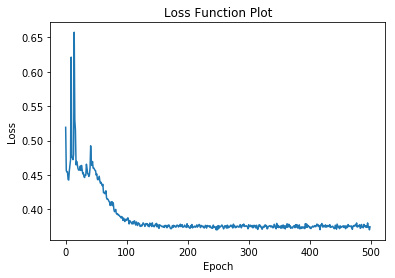

In [57]:
plt.plot(model_history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

#### Predictions on train data

In [58]:
train_pred = model.predict_classes(X_train)
train_pred_prob = model.predict(X_train)

##### Confusion matrix on train data

In [59]:
confusion_matrix_train = confusion_matrix(y_train, train_pred)
print(confusion_matrix_train)

[[33052     0]
 [ 7678     0]]


#### Predictions on test data

In [60]:
test_pred = model.predict_classes(X_test)
test_pred_prob = model.predict(X_test)

#### Confusion matrix on test data

In [61]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
print(confusion_matrix_test)

[[14165     0]
 [ 3291     0]]


##### Accuracy, True Negative Rate and True Positive Rate on both train and test

In [62]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR     : ",TNR_Train)
print("Train TPR     : ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

print('------------------------------------')
Accuracy_Test = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
TPR_Test = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test TNR      : ",TNR_Test)
print("Test TPR      : ",TPR_Test)
print("Test Accuracy : ",Accuracy_Test)

Train TNR     :  1.0
Train TPR     :  0.0
Train Accuracy:  0.8114903019887061
------------------------------------
Test TNR      :  1.0
Test TPR      :  0.0
Test Accuracy :  0.8114688359303391


### Cyclic Learning rate finder

In [63]:
class CyclicLR(Callback):
    
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with 
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or per-cycle basis.
    
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle with no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
 
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

#### A basic triangular cycle with no amplitude scaling.

In [64]:
model = create_model()

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 25)                550       
_________________________________________________________________
dropout_7 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 15)                390       
_________________________________________________________________
dropout_8 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [66]:
clr_triangular = CyclicLR(base_lr=LR_MIN, max_lr=LR_MAX, step_size=2*N_STEPS, mode='triangular')

In [67]:
model_history = model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[clr_triangular])

Epoch 1/500
40730/40730 [==============================] - 3s 82us/step - loss: 0.8314 - acc: 0.7993
Epoch 2/500
40730/40730 [==============================] - 2s 59us/step - loss: 0.4225 - acc: 0.8113
Epoch 3/500
40730/40730 [==============================] - 2s 59us/step - loss: 0.4478 - acc: 0.8107
Epoch 4/500
40730/40730 [==============================] - 2s 61us/step - loss: 0.4383 - acc: 0.8115
Epoch 5/500
40730/40730 [==============================] - 2s 59us/step - loss: 0.4240 - acc: 0.8118
Epoch 6/500
40730/40730 [==============================] - 2s 61us/step - loss: 0.4437 - acc: 0.8107
Epoch 7/500
40730/40730 [==============================] - 3s 63us/step - loss: 0.4477 - acc: 0.8111
Epoch 8/500
40730/40730 [==============================] - 3s 65us/step - loss: 0.4194 - acc: 0.8114
Epoch 9/500
40730/40730 [==============================] - 3s 64us/step - loss: 0.4046 - acc: 0.8115
Epoch 10/500
40730/40730 [==============================] - 2s 61us/step - loss: 0.4269 - a

40730/40730 [==============================] - 3s 66us/step - loss: 0.4815 - acc: 0.8115
Epoch 82/500
40730/40730 [==============================] - 3s 63us/step - loss: 0.4755 - acc: 0.8115
Epoch 83/500
40730/40730 [==============================] - 3s 62us/step - loss: 0.4856 - acc: 0.8115
Epoch 84/500
40730/40730 [==============================] - 3s 79us/step - loss: 0.5092 - acc: 0.8100
Epoch 85/500
40730/40730 [==============================] - 3s 78us/step - loss: 0.4723 - acc: 0.8110
Epoch 86/500
40730/40730 [==============================] - 3s 70us/step - loss: 0.4806 - acc: 0.8114
Epoch 87/500
40730/40730 [==============================] - 3s 73us/step - loss: 0.4620 - acc: 0.8114
Epoch 88/500
40730/40730 [==============================] - 4s 88us/step - loss: 0.4638 - acc: 0.8115
Epoch 89/500
40730/40730 [==============================] - 3s 77us/step - loss: 0.4696 - acc: 0.8114
Epoch 90/500
40730/40730 [==============================] - 3s 72us/step - loss: 0.5489 - acc: 

40730/40730 [==============================] - 2s 41us/step - loss: 0.4755 - acc: 0.8115
Epoch 161/500
40730/40730 [==============================] - 2s 41us/step - loss: 0.4728 - acc: 0.8115
Epoch 162/500
40730/40730 [==============================] - 2s 41us/step - loss: 0.4788 - acc: 0.8113
Epoch 163/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.4666 - acc: 0.8115
Epoch 164/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.4701 - acc: 0.8115
Epoch 165/500
40730/40730 [==============================] - 2s 45us/step - loss: 0.4703 - acc: 0.8109
Epoch 166/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.4606 - acc: 0.8115
Epoch 167/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.4789 - acc: 0.8115
Epoch 168/500
40730/40730 [==============================] - 2s 45us/step - loss: 0.4651 - acc: 0.8115
Epoch 169/500
40730/40730 [==============================] - 2s 45us/step - loss: 0.454

40730/40730 [==============================] - 2s 37us/step - loss: 0.5701 - acc: 0.8095
Epoch 240/500
40730/40730 [==============================] - 2s 37us/step - loss: 0.5122 - acc: 0.8097
Epoch 241/500
40730/40730 [==============================] - 2s 38us/step - loss: 0.4799 - acc: 0.8115
Epoch 242/500
40730/40730 [==============================] - 2s 37us/step - loss: 0.4786 - acc: 0.8115
Epoch 243/500
40730/40730 [==============================] - 2s 37us/step - loss: 0.4622 - acc: 0.8115
Epoch 244/500
40730/40730 [==============================] - 2s 38us/step - loss: 0.4570 - acc: 0.8115
Epoch 245/500
40730/40730 [==============================] - 2s 37us/step - loss: 0.4624 - acc: 0.8115
Epoch 246/500
40730/40730 [==============================] - 2s 37us/step - loss: 0.4653 - acc: 0.8115
Epoch 247/500
40730/40730 [==============================] - 2s 38us/step - loss: 0.4700 - acc: 0.8110
Epoch 248/500
40730/40730 [==============================] - 2s 37us/step - loss: 0.456

40730/40730 [==============================] - 3s 64us/step - loss: 0.5936 - acc: 0.8115
Epoch 319/500
40730/40730 [==============================] - 2s 59us/step - loss: 0.4746 - acc: 0.8115
Epoch 320/500
40730/40730 [==============================] - 3s 66us/step - loss: 0.4759 - acc: 0.8115
Epoch 321/500
40730/40730 [==============================] - 3s 71us/step - loss: 0.4701 - acc: 0.8115
Epoch 322/500
40730/40730 [==============================] - 3s 72us/step - loss: 0.5108 - acc: 0.8115
Epoch 323/500
40730/40730 [==============================] - 3s 66us/step - loss: 0.4982 - acc: 0.8115
Epoch 324/500
40730/40730 [==============================] - 3s 64us/step - loss: 0.5066 - acc: 0.8115
Epoch 325/500
40730/40730 [==============================] - 3s 62us/step - loss: 0.5206 - acc: 0.8114
Epoch 326/500
40730/40730 [==============================] - 2s 60us/step - loss: 0.4735 - acc: 0.8115
Epoch 327/500
40730/40730 [==============================] - 2s 59us/step - loss: 0.474

40730/40730 [==============================] - 2s 52us/step - loss: 0.4863 - acc: 0.8115
Epoch 398/500
40730/40730 [==============================] - 2s 50us/step - loss: 0.4974 - acc: 0.8115
Epoch 399/500
40730/40730 [==============================] - 2s 50us/step - loss: 0.5264 - acc: 0.8114
Epoch 400/500
40730/40730 [==============================] - 2s 50us/step - loss: 0.4934 - acc: 0.8115
Epoch 401/500
40730/40730 [==============================] - 2s 48us/step - loss: 0.4810 - acc: 0.8115
Epoch 402/500
40730/40730 [==============================] - 2s 48us/step - loss: 0.4863 - acc: 0.8115
Epoch 403/500
40730/40730 [==============================] - 2s 47us/step - loss: 0.4836 - acc: 0.8115
Epoch 404/500
40730/40730 [==============================] - 2s 47us/step - loss: 0.4996 - acc: 0.8115
Epoch 405/500
40730/40730 [==============================] - 2s 48us/step - loss: 0.5024 - acc: 0.8115
Epoch 406/500
40730/40730 [==============================] - 2s 47us/step - loss: 0.551

40730/40730 [==============================] - 2s 51us/step - loss: 0.5919 - acc: 0.8107
Epoch 477/500
40730/40730 [==============================] - 2s 50us/step - loss: 0.4794 - acc: 0.8115
Epoch 478/500
40730/40730 [==============================] - 2s 49us/step - loss: 0.4748 - acc: 0.8115
Epoch 479/500
40730/40730 [==============================] - 2s 48us/step - loss: 0.4765 - acc: 0.8115
Epoch 480/500
40730/40730 [==============================] - 2s 47us/step - loss: 0.5710 - acc: 0.8114
Epoch 481/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.4871 - acc: 0.8115
Epoch 482/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.4844 - acc: 0.8111
Epoch 483/500
40730/40730 [==============================] - 2s 50us/step - loss: 0.4823 - acc: 0.8115
Epoch 484/500
40730/40730 [==============================] - 2s 49us/step - loss: 0.4655 - acc: 0.8115
Epoch 485/500
40730/40730 [==============================] - 2s 47us/step - loss: 0.471

#### Plot

In [68]:
print(model_history.history.keys())

dict_keys(['loss', 'acc'])


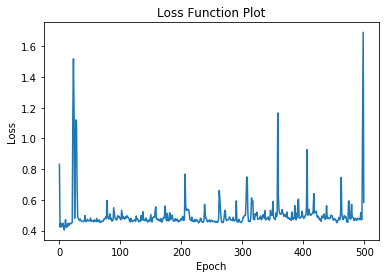

In [69]:
plt.plot(model_history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

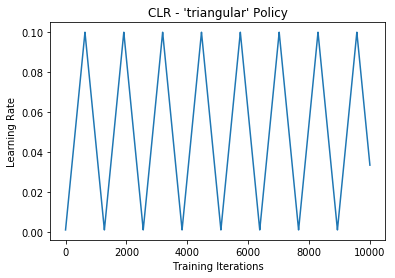

In [70]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'][:10000], clr_triangular.history['lr'][:10000])

#### Predictions on train data

In [71]:
train_pred = model.predict_classes(X_train)
train_pred_prob = model.predict(X_train)

##### Confusion matrix on train data

In [72]:
confusion_matrix_train = confusion_matrix(y_train, train_pred)
print(confusion_matrix_train)

[[33052     0]
 [ 7678     0]]


#### Predictions on test data

In [73]:
test_pred = model.predict_classes(X_test)
test_pred_prob = model.predict(X_test)

#### Confusion matrix on test data

In [74]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
print(confusion_matrix_test)

[[14165     0]
 [ 3291     0]]


##### Accuracy, True Negative Rate and True Positive Rate on both train and test

In [75]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR     : ",TNR_Train)
print("Train TPR     : ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

print('------------------------------------')

Accuracy_Test = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
TPR_Test = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test TNR      : ",TNR_Test)
print("Test TPR      : ",TPR_Test)
print("Test Accuracy : ",Accuracy_Test)

Train TNR     :  1.0
Train TPR     :  0.0
Train Accuracy:  0.8114903019887061
------------------------------------
Test TNR      :  1.0
Test TPR      :  0.0
Test Accuracy :  0.8114688359303391


#### A basic triangular cycle that scales initial amplitude by half each cycle.

In [76]:
model = create_model()

In [77]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 25)                550       
_________________________________________________________________
dropout_9 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 15)                390       
_________________________________________________________________
dropout_10 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [78]:
clr_triangular2 = CyclicLR(base_lr=LR_MIN, max_lr=LR_MAX, step_size=2*N_STEPS, mode='triangular2')

In [79]:
model_history = model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[clr_triangular2])

Epoch 1/500
40730/40730 [==============================] - 3s 64us/step - loss: 0.5686 - acc: 0.8050
Epoch 2/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.4198 - acc: 0.8097
Epoch 3/500
40730/40730 [==============================] - 2s 47us/step - loss: 0.4463 - acc: 0.8113
Epoch 4/500
40730/40730 [==============================] - 2s 48us/step - loss: 0.4480 - acc: 0.8114
Epoch 5/500
40730/40730 [==============================] - 2s 48us/step - loss: 0.4342 - acc: 0.8115
Epoch 6/500
40730/40730 [==============================] - 2s 49us/step - loss: 0.4264 - acc: 0.8115
Epoch 7/500
40730/40730 [==============================] - 2s 61us/step - loss: 0.4747 - acc: 0.8099
Epoch 8/500
40730/40730 [==============================] - 3s 70us/step - loss: 0.4349 - acc: 0.8106
Epoch 9/500
40730/40730 [==============================] - 3s 84us/step - loss: 0.4303 - acc: 0.8109
Epoch 10/500
40730/40730 [==============================] - 3s 69us/step - loss: 0.4194 - a

40730/40730 [==============================] - 2s 61us/step - loss: 0.3328 - acc: 0.8698
Epoch 82/500
40730/40730 [==============================] - 2s 60us/step - loss: 0.3280 - acc: 0.8704
Epoch 83/500
40730/40730 [==============================] - 2s 59us/step - loss: 0.3280 - acc: 0.8698
Epoch 84/500
40730/40730 [==============================] - 2s 58us/step - loss: 0.3292 - acc: 0.8671
Epoch 85/500
40730/40730 [==============================] - 2s 54us/step - loss: 0.3272 - acc: 0.8713
Epoch 86/500
40730/40730 [==============================] - 2s 50us/step - loss: 0.3240 - acc: 0.8685
Epoch 87/500
40730/40730 [==============================] - 2s 48us/step - loss: 0.3278 - acc: 0.8696
Epoch 88/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.3282 - acc: 0.8694
Epoch 89/500
40730/40730 [==============================] - 2s 45us/step - loss: 0.3240 - acc: 0.8714
Epoch 90/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.3270 - acc: 

40730/40730 [==============================] - 2s 59us/step - loss: 0.3030 - acc: 0.8833
Epoch 161/500
40730/40730 [==============================] - 2s 59us/step - loss: 0.3048 - acc: 0.8803
Epoch 162/500
40730/40730 [==============================] - 3s 61us/step - loss: 0.3040 - acc: 0.8796
Epoch 163/500
40730/40730 [==============================] - 3s 63us/step - loss: 0.3063 - acc: 0.8797
Epoch 164/500
40730/40730 [==============================] - 2s 59us/step - loss: 0.3073 - acc: 0.8685
Epoch 165/500
40730/40730 [==============================] - 2s 59us/step - loss: 0.3026 - acc: 0.8519
Epoch 166/500
40730/40730 [==============================] - 2s 59us/step - loss: 0.3003 - acc: 0.8535
Epoch 167/500
40730/40730 [==============================] - 3s 65us/step - loss: 0.3015 - acc: 0.8499
Epoch 168/500
40730/40730 [==============================] - 3s 65us/step - loss: 0.3009 - acc: 0.8523
Epoch 169/500
40730/40730 [==============================] - 3s 63us/step - loss: 0.302

40730/40730 [==============================] - 3s 71us/step - loss: 0.2979 - acc: 0.8875
Epoch 240/500
40730/40730 [==============================] - 3s 71us/step - loss: 0.2992 - acc: 0.8842
Epoch 241/500
40730/40730 [==============================] - 3s 83us/step - loss: 0.2994 - acc: 0.8853
Epoch 242/500
40730/40730 [==============================] - 3s 76us/step - loss: 0.2968 - acc: 0.8884
Epoch 243/500
40730/40730 [==============================] - 3s 73us/step - loss: 0.2990 - acc: 0.8845
Epoch 244/500
40730/40730 [==============================] - 3s 68us/step - loss: 0.2965 - acc: 0.8825
Epoch 245/500
40730/40730 [==============================] - 3s 63us/step - loss: 0.2967 - acc: 0.8832
Epoch 246/500
40730/40730 [==============================] - 3s 64us/step - loss: 0.2970 - acc: 0.8522
Epoch 247/500
40730/40730 [==============================] - 3s 63us/step - loss: 0.2970 - acc: 0.8841
Epoch 248/500
40730/40730 [==============================] - 3s 63us/step - loss: 0.294

40730/40730 [==============================] - 2s 59us/step - loss: 0.2925 - acc: 0.8915
Epoch 319/500
40730/40730 [==============================] - 2s 53us/step - loss: 0.2934 - acc: 0.8902
Epoch 320/500
40730/40730 [==============================] - 2s 51us/step - loss: 0.2931 - acc: 0.8900
Epoch 321/500
40730/40730 [==============================] - 2s 50us/step - loss: 0.2921 - acc: 0.8900
Epoch 322/500
40730/40730 [==============================] - 2s 48us/step - loss: 0.2939 - acc: 0.8896
Epoch 323/500
40730/40730 [==============================] - 2s 48us/step - loss: 0.2929 - acc: 0.8886
Epoch 324/500
40730/40730 [==============================] - 2s 48us/step - loss: 0.2930 - acc: 0.8923
Epoch 325/500
40730/40730 [==============================] - 2s 48us/step - loss: 0.2936 - acc: 0.8899
Epoch 326/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.2959 - acc: 0.8906
Epoch 327/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.293

40730/40730 [==============================] - 2s 44us/step - loss: 0.2967 - acc: 0.8903
Epoch 398/500
40730/40730 [==============================] - 2s 41us/step - loss: 0.2937 - acc: 0.8920
Epoch 399/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.2902 - acc: 0.8896
Epoch 400/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.2937 - acc: 0.8901
Epoch 401/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.2920 - acc: 0.8891
Epoch 402/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.2914 - acc: 0.8922
Epoch 403/500
40730/40730 [==============================] - 2s 47us/step - loss: 0.2933 - acc: 0.8907
Epoch 404/500
40730/40730 [==============================] - 2s 51us/step - loss: 0.2919 - acc: 0.8919
Epoch 405/500
40730/40730 [==============================] - 2s 52us/step - loss: 0.2932 - acc: 0.8920
Epoch 406/500
40730/40730 [==============================] - 2s 55us/step - loss: 0.294

40730/40730 [==============================] - 3s 69us/step - loss: 0.2901 - acc: 0.8912
Epoch 477/500
40730/40730 [==============================] - 3s 68us/step - loss: 0.2901 - acc: 0.8898
Epoch 478/500
40730/40730 [==============================] - 3s 69us/step - loss: 0.2910 - acc: 0.8902
Epoch 479/500
40730/40730 [==============================] - 3s 69us/step - loss: 0.2925 - acc: 0.8901
Epoch 480/500
40730/40730 [==============================] - 3s 77us/step - loss: 0.2964 - acc: 0.8892
Epoch 481/500
40730/40730 [==============================] - 3s 76us/step - loss: 0.2932 - acc: 0.8883
Epoch 482/500
40730/40730 [==============================] - 3s 74us/step - loss: 0.2940 - acc: 0.8892
Epoch 483/500
40730/40730 [==============================] - 3s 84us/step - loss: 0.2912 - acc: 0.8903
Epoch 484/500
40730/40730 [==============================] - 4s 93us/step - loss: 0.2916 - acc: 0.8929
Epoch 485/500
40730/40730 [==============================] - 4s 102us/step - loss: 0.29

#### Plot

In [80]:
print(model_history.history.keys())

dict_keys(['loss', 'acc'])


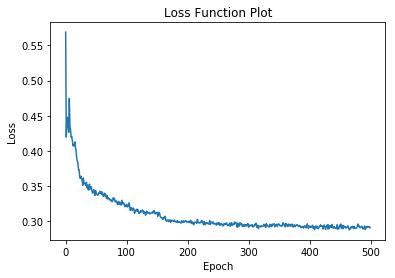

In [81]:
plt.plot(model_history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

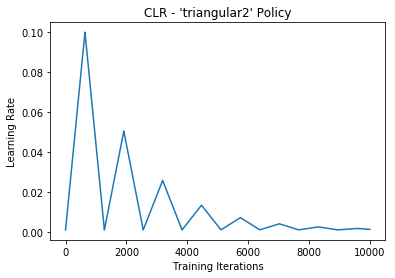

In [82]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular2' Policy")
plt.plot(clr_triangular2.history['iterations'][:10000], clr_triangular2.history['lr'][:10000])

#### Predictions on train data

In [83]:
train_pred = model.predict_classes(X_train)
train_pred_prob = model.predict(X_train)

#### Predictions on test data

In [84]:
test_pred = model.predict_classes(X_test)
test_pred_prob = model.predict(X_test)

##### Confusion matrix on train data

In [85]:
confusion_matrix_train = confusion_matrix(y_train, train_pred)
print(confusion_matrix_train)

[[31956  1096]
 [ 3023  4655]]


#### Confusion matrix on test data

In [86]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
print(confusion_matrix_test)

[[13663   502]
 [ 1326  1965]]


##### Accuracy, True Negative Rate and True Positive Rate on both train and test

In [87]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR     : ",TNR_Train)
print("Train TPR     : ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

print('------------------------------------')
Accuracy_Test = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
TPR_Test = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test TNR      : ",TNR_Test)
print("Test TPR      : ",TPR_Test)
print("Test Accuracy : ",Accuracy_Test)

Train TNR     :  0.9668401307031345
Train TPR     :  0.6062776764782496
Train Accuracy:  0.8988706113429904
------------------------------------
Test TNR      :  0.9645605365337099
Test TPR      :  0.5970829535095715
Test Accuracy :  0.8952795600366636


#### A cycle that scales initial amplitude by gamma**(cycle iterations) at each cycle iteration.

In [88]:
model = create_model()

In [89]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 25)                550       
_________________________________________________________________
dropout_11 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 15)                390       
_________________________________________________________________
dropout_12 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [90]:
clr_triangular3 = CyclicLR(base_lr=LR_MIN, max_lr=LR_MAX, mode='exp_range', gamma=0.88884, step_size=10)

In [91]:
model_history = model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[clr_triangular3])

Epoch 1/500
40730/40730 [==============================] - 3s 63us/step - loss: 0.8085 - acc: 0.8074
Epoch 2/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.4829 - acc: 0.8104
Epoch 3/500
40730/40730 [==============================] - 2s 45us/step - loss: 0.4492 - acc: 0.8103
Epoch 4/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.4214 - acc: 0.8106
Epoch 5/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.4070 - acc: 0.8115
Epoch 6/500
40730/40730 [==============================] - 2s 47us/step - loss: 0.3949 - acc: 0.8126
Epoch 7/500
40730/40730 [==============================] - 2s 47us/step - loss: 0.3815 - acc: 0.8123
Epoch 8/500
40730/40730 [==============================] - 2s 47us/step - loss: 0.3758 - acc: 0.8130
Epoch 9/500
40730/40730 [==============================] - 2s 47us/step - loss: 0.3656 - acc: 0.8131
Epoch 10/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.3590 - a

40730/40730 [==============================] - 4s 88us/step - loss: 0.2788 - acc: 0.8899
Epoch 82/500
40730/40730 [==============================] - 4s 92us/step - loss: 0.2761 - acc: 0.8916
Epoch 83/500
40730/40730 [==============================] - 4s 89us/step - loss: 0.2762 - acc: 0.8897
Epoch 84/500
40730/40730 [==============================] - 4s 95us/step - loss: 0.2738 - acc: 0.8934
Epoch 85/500
40730/40730 [==============================] - 4s 103us/step - loss: 0.2750 - acc: 0.8909
Epoch 86/500
40730/40730 [==============================] - 4s 89us/step - loss: 0.2755 - acc: 0.8921
Epoch 87/500
40730/40730 [==============================] - 4s 92us/step - loss: 0.2754 - acc: 0.8932
Epoch 88/500
40730/40730 [==============================] - 4s 90us/step - loss: 0.2765 - acc: 0.8913
Epoch 89/500
40730/40730 [==============================] - 3s 84us/step - loss: 0.2740 - acc: 0.8912
Epoch 90/500
40730/40730 [==============================] - 3s 84us/step - loss: 0.2749 - acc:

40730/40730 [==============================] - 2s 46us/step - loss: 0.2713 - acc: 0.8940
Epoch 161/500
40730/40730 [==============================] - 2s 45us/step - loss: 0.2695 - acc: 0.8940
Epoch 162/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.2674 - acc: 0.8945
Epoch 163/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.2682 - acc: 0.8950
Epoch 164/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.2680 - acc: 0.8950
Epoch 165/500
40730/40730 [==============================] - 2s 49us/step - loss: 0.2706 - acc: 0.8932
Epoch 166/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.2679 - acc: 0.8934
Epoch 167/500
40730/40730 [==============================] - 2s 45us/step - loss: 0.2695 - acc: 0.8950
Epoch 168/500
40730/40730 [==============================] - 2s 48us/step - loss: 0.2700 - acc: 0.8931
Epoch 169/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.270

40730/40730 [==============================] - 3s 61us/step - loss: 0.2665 - acc: 0.8972
Epoch 240/500
40730/40730 [==============================] - 2s 58us/step - loss: 0.2680 - acc: 0.8951
Epoch 241/500
40730/40730 [==============================] - 2s 58us/step - loss: 0.2679 - acc: 0.8946
Epoch 242/500
40730/40730 [==============================] - 2s 54us/step - loss: 0.2667 - acc: 0.8965
Epoch 243/500
40730/40730 [==============================] - 2s 55us/step - loss: 0.2666 - acc: 0.8959
Epoch 244/500
40730/40730 [==============================] - 2s 52us/step - loss: 0.2672 - acc: 0.8954
Epoch 245/500
40730/40730 [==============================] - 2s 49us/step - loss: 0.2691 - acc: 0.8959
Epoch 246/500
40730/40730 [==============================] - 2s 48us/step - loss: 0.2681 - acc: 0.8962
Epoch 247/500
40730/40730 [==============================] - 2s 47us/step - loss: 0.2696 - acc: 0.8963
Epoch 248/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.267

40730/40730 [==============================] - 2s 46us/step - loss: 0.2669 - acc: 0.8963
Epoch 319/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.2664 - acc: 0.8963
Epoch 320/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.2671 - acc: 0.8973
Epoch 321/500
40730/40730 [==============================] - 2s 46us/step - loss: 0.2644 - acc: 0.8960
Epoch 322/500
40730/40730 [==============================] - 2s 45us/step - loss: 0.2657 - acc: 0.8951
Epoch 323/500
40730/40730 [==============================] - 2s 45us/step - loss: 0.2661 - acc: 0.8961
Epoch 324/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.2650 - acc: 0.8955
Epoch 325/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.2692 - acc: 0.8941
Epoch 326/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.2634 - acc: 0.8974
Epoch 327/500
40730/40730 [==============================] - 2s 47us/step - loss: 0.264

40730/40730 [==============================] - 2s 58us/step - loss: 0.2607 - acc: 0.8977
Epoch 398/500
40730/40730 [==============================] - 3s 63us/step - loss: 0.2631 - acc: 0.8978
Epoch 399/500
40730/40730 [==============================] - 2s 60us/step - loss: 0.2640 - acc: 0.8970
Epoch 400/500
40730/40730 [==============================] - 3s 65us/step - loss: 0.2653 - acc: 0.8957
Epoch 401/500
40730/40730 [==============================] - 2s 61us/step - loss: 0.2659 - acc: 0.8955
Epoch 402/500
40730/40730 [==============================] - 2s 61us/step - loss: 0.2654 - acc: 0.8996
Epoch 403/500
40730/40730 [==============================] - 3s 64us/step - loss: 0.2638 - acc: 0.8982
Epoch 404/500
40730/40730 [==============================] - 2s 60us/step - loss: 0.2663 - acc: 0.8958
Epoch 405/500
40730/40730 [==============================] - 2s 58us/step - loss: 0.2659 - acc: 0.8959
Epoch 406/500
40730/40730 [==============================] - 2s 55us/step - loss: 0.264

40730/40730 [==============================] - 2s 46us/step - loss: 0.2662 - acc: 0.8966
Epoch 477/500
40730/40730 [==============================] - 2s 45us/step - loss: 0.2635 - acc: 0.8962
Epoch 478/500
40730/40730 [==============================] - 2s 43us/step - loss: 0.2632 - acc: 0.8984
Epoch 479/500
40730/40730 [==============================] - 2s 43us/step - loss: 0.2648 - acc: 0.8964
Epoch 480/500
40730/40730 [==============================] - 2s 43us/step - loss: 0.2635 - acc: 0.8960
Epoch 481/500
40730/40730 [==============================] - 2s 41us/step - loss: 0.2638 - acc: 0.8969
Epoch 482/500
40730/40730 [==============================] - 2s 42us/step - loss: 0.2638 - acc: 0.8979
Epoch 483/500
40730/40730 [==============================] - 2s 44us/step - loss: 0.2641 - acc: 0.8975
Epoch 484/500
40730/40730 [==============================] - 2s 43us/step - loss: 0.2642 - acc: 0.8962
Epoch 485/500
40730/40730 [==============================] - 2s 41us/step - loss: 0.264

#### Plot

In [92]:
print(model_history.history.keys())

dict_keys(['loss', 'acc'])


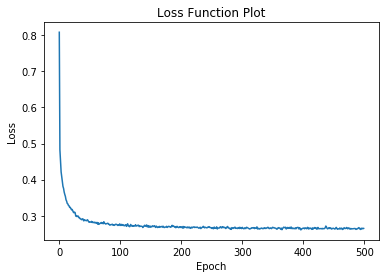

In [93]:
plt.plot(model_history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

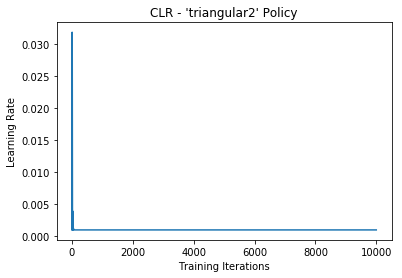

In [94]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular2' Policy")
plt.plot(clr_triangular3.history['iterations'][:10000], clr_triangular3.history['lr'][:10000])

#### Predictions on train data

In [95]:
train_pred = model.predict_classes(X_train)
train_pred_prob = model.predict(X_train)

#### Predictions on test data

In [96]:
test_pred = model.predict_classes(X_test)
test_pred_prob = model.predict(X_test)

##### confusion matrix on train data

In [97]:
confusion_matrix_train = confusion_matrix(y_train, train_pred)
print(confusion_matrix_train)

[[30790  2262]
 [ 1725  5953]]


#### confusion matrix on test data

In [98]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
print(confusion_matrix_test)

[[13120  1045]
 [  779  2512]]


##### Accuracy, True Negative Rate and True Positive Rate on both train and test data

In [99]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR     : ",TNR_Train)
print("Train TPR     : ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

print('------------------------------------')
Accuracy_Test = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
TPR_Test = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test TNR      : ",TNR_Test)
print("Test TPR      : ",TPR_Test)
print("Test Accuracy : ",Accuracy_Test)

Train TNR     :  0.931562386542418
Train TPR     :  0.7753321177389946
Train Accuracy:  0.9021114657500614
------------------------------------
Test TNR      :  0.9262266148958701
Test TPR      :  0.7632938316621087
Test Accuracy :  0.8955087076076994


### Cosine Annealing Learning Rate

    The cosine annealing schedule is an example of an aggressive learning rate schedule where learning rate starts high and is dropped relatively rapidly to a minimum value near zero before being increased again to the maximum.

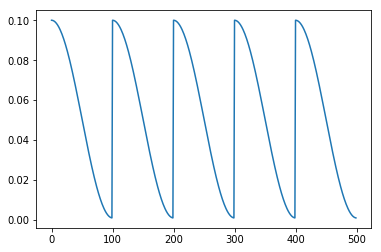

In [100]:
# example of a cosine annealing learning rate schedule
 
# cosine annealing learning rate schedule
def cosine_annealing(epoch, n_epochs, n_cycles, lrate_min, lrate_max):
    epochs_per_cycle = floor(n_epochs/n_cycles)
    cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
    return lrate_min + (lrate_max-lrate_min)/2 * (cos(cos_inner) + 1)
 
# create learning rate series
N_CYCLES = 5

series = [cosine_annealing(i, N_EPOCHS, N_CYCLES, LR_MIN, LR_MAX) for i in range(N_EPOCHS)]

# plot series
plt.plot(series)
plt.show()

Observation: 

    The learning rate starts at the maximum value at epoch 0 and decreases rapidly to epoch 49, before being reset at epoch 50, the start of the next cycle. The cycle is repeated five times as specified in the argument.

In [101]:
# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(Callback):

    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, lrate_min, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lr_min = lrate_min
        self.lrates = list()
 
    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max, lrate_min):
        epochs_per_cycle = floor(n_epochs/n_cycles)
        cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_min + (lrate_max-lrate_min)/2 * (cos(cos_inner) + 1)
 
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max, self.lr_min)
        # set learning rate
        K.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

In [102]:
model = create_model()

In [103]:
# define learning rate callback
ca = CosineAnnealingLearningRateSchedule(N_EPOCHS, N_CYCLES, LR_MAX, LR_MIN)

In [104]:
# fit model
history = model.fit(X_train, y_train, epochs=N_EPOCHS, callbacks=[ca])

Epoch 1/500
40730/40730 [==============================] - 6s 136us/step - loss: 1.2933 - acc: 0.7866
Epoch 2/500
40730/40730 [==============================] - 5s 116us/step - loss: 1.0306 - acc: 0.8080
Epoch 3/500
40730/40730 [==============================] - 5s 122us/step - loss: 1.9807 - acc: 0.8102
Epoch 4/500
40730/40730 [==============================] - 5s 123us/step - loss: 2.5037 - acc: 0.8104
Epoch 5/500
40730/40730 [==============================] - 5s 126us/step - loss: 2.8716 - acc: 0.8110
Epoch 6/500
40730/40730 [==============================] - 5s 124us/step - loss: 2.9063 - acc: 0.8108
Epoch 7/500
40730/40730 [==============================] - 5s 124us/step - loss: 2.9508 - acc: 0.8112
Epoch 8/500
40730/40730 [==============================] - 5s 119us/step - loss: 2.9166 - acc: 0.8114
Epoch 9/500
40730/40730 [==============================] - 6s 136us/step - loss: 2.9463 - acc: 0.8060
Epoch 10/500
40730/40730 [==============================] - 7s 161us/step - loss: 

40730/40730 [==============================] - 6s 136us/step - loss: 0.4577 - acc: 0.8115
Epoch 81/500
40730/40730 [==============================] - 5s 132us/step - loss: 0.4661 - acc: 0.8108
Epoch 82/500
40730/40730 [==============================] - 6s 146us/step - loss: 0.4923 - acc: 0.8091
Epoch 83/500
40730/40730 [==============================] - 5s 124us/step - loss: 0.4548 - acc: 0.8115
Epoch 84/500
40730/40730 [==============================] - 4s 106us/step - loss: 0.4644 - acc: 0.8110
Epoch 85/500
40730/40730 [==============================] - 4s 97us/step - loss: 0.4578 - acc: 0.8115
Epoch 86/500
40730/40730 [==============================] - 4s 102us/step - loss: 0.4631 - acc: 0.8108
Epoch 87/500
40730/40730 [==============================] - 4s 96us/step - loss: 0.4573 - acc: 0.8114
Epoch 88/500
40730/40730 [==============================] - 4s 96us/step - loss: 0.4605 - acc: 0.8115
Epoch 89/500
40730/40730 [==============================] - 4s 94us/step - loss: 0.4532 -

40730/40730 [==============================] - 4s 98us/step - loss: 0.4846 - acc: 0.8115
Epoch 160/500
40730/40730 [==============================] - 4s 98us/step - loss: 0.4847 - acc: 0.8115
Epoch 161/500
40730/40730 [==============================] - 4s 103us/step - loss: 0.4847 - acc: 0.8115
Epoch 162/500
40730/40730 [==============================] - 4s 105us/step - loss: 0.4846 - acc: 0.8115
Epoch 163/500
40730/40730 [==============================] - 4s 103us/step - loss: 0.4844 - acc: 0.8115
Epoch 164/500
40730/40730 [==============================] - 4s 103us/step - loss: 0.4845 - acc: 0.8115
Epoch 165/500
40730/40730 [==============================] - 4s 104us/step - loss: 0.4844 - acc: 0.8115
Epoch 166/500
40730/40730 [==============================] - 4s 101us/step - loss: 0.4846 - acc: 0.8115
Epoch 167/500
40730/40730 [==============================] - 4s 98us/step - loss: 0.4845 - acc: 0.8115
Epoch 168/500
40730/40730 [==============================] - 4s 99us/step - loss:

40730/40730 [==============================] - 4s 99us/step - loss: 0.4852 - acc: 0.8115
Epoch 238/500
40730/40730 [==============================] - 4s 100us/step - loss: 0.4854 - acc: 0.8115
Epoch 239/500
40730/40730 [==============================] - 4s 100us/step - loss: 0.4852 - acc: 0.8115
Epoch 240/500
40730/40730 [==============================] - 4s 97us/step - loss: 0.4853 - acc: 0.8115
Epoch 241/500
40730/40730 [==============================] - 4s 94us/step - loss: 0.4852 - acc: 0.8115
Epoch 242/500
40730/40730 [==============================] - 4s 94us/step - loss: 0.4854 - acc: 0.8115
Epoch 243/500
40730/40730 [==============================] - 4s 93us/step - loss: 0.4850 - acc: 0.8115
Epoch 244/500
40730/40730 [==============================] - 4s 97us/step - loss: 0.4850 - acc: 0.8115
Epoch 245/500
40730/40730 [==============================] - 4s 100us/step - loss: 0.4850 - acc: 0.8115
Epoch 246/500
40730/40730 [==============================] - 4s 99us/step - loss: 0.

40730/40730 [==============================] - 3s 85us/step - loss: 0.4859 - acc: 0.8115
Epoch 317/500
40730/40730 [==============================] - 3s 85us/step - loss: 0.4856 - acc: 0.8115
Epoch 318/500
40730/40730 [==============================] - 3s 85us/step - loss: 0.4855 - acc: 0.8115
Epoch 319/500
40730/40730 [==============================] - 3s 85us/step - loss: 0.4859 - acc: 0.8115
Epoch 320/500
40730/40730 [==============================] - 3s 85us/step - loss: 0.4858 - acc: 0.8115
Epoch 321/500
40730/40730 [==============================] - 3s 84us/step - loss: 0.4854 - acc: 0.8115
Epoch 322/500
40730/40730 [==============================] - 3s 84us/step - loss: 0.4854 - acc: 0.8115
Epoch 323/500
40730/40730 [==============================] - 4s 86us/step - loss: 0.4855 - acc: 0.8115
Epoch 324/500
40730/40730 [==============================] - 4s 86us/step - loss: 0.4853 - acc: 0.8115
Epoch 325/500
40730/40730 [==============================] - 4s 88us/step - loss: 0.485

40730/40730 [==============================] - 5s 116us/step - loss: 0.4841 - acc: 0.8115
Epoch 396/500
40730/40730 [==============================] - 4s 109us/step - loss: 0.4841 - acc: 0.8115
Epoch 397/500
40730/40730 [==============================] - 4s 110us/step - loss: 0.4841 - acc: 0.8115
Epoch 398/500
40730/40730 [==============================] - 4s 102us/step - loss: 0.4841 - acc: 0.8115
Epoch 399/500
40730/40730 [==============================] - 4s 103us/step - loss: 0.4841 - acc: 0.8115
Epoch 400/500
40730/40730 [==============================] - 4s 101us/step - loss: 0.4841 - acc: 0.8115
Epoch 401/500
40730/40730 [==============================] - 4s 98us/step - loss: 0.4856 - acc: 0.8115
Epoch 402/500
40730/40730 [==============================] - 4s 97us/step - loss: 0.4856 - acc: 0.8115
Epoch 403/500
40730/40730 [==============================] - 4s 97us/step - loss: 0.4855 - acc: 0.8115
Epoch 404/500
40730/40730 [==============================] - 4s 94us/step - loss:

40730/40730 [==============================] - 4s 89us/step - loss: 0.4845 - acc: 0.8115
Epoch 474/500
40730/40730 [==============================] - 4s 89us/step - loss: 0.4844 - acc: 0.8115
Epoch 475/500
40730/40730 [==============================] - 4s 94us/step - loss: 0.4844 - acc: 0.8115
Epoch 476/500
40730/40730 [==============================] - 4s 95us/step - loss: 0.4842 - acc: 0.8115
Epoch 477/500
40730/40730 [==============================] - 4s 102us/step - loss: 0.4843 - acc: 0.8115
Epoch 478/500
40730/40730 [==============================] - 4s 99us/step - loss: 0.4845 - acc: 0.8115
Epoch 479/500
40730/40730 [==============================] - 4s 100us/step - loss: 0.4842 - acc: 0.8115
Epoch 480/500
40730/40730 [==============================] - 4s 99us/step - loss: 0.4842 - acc: 0.8115
Epoch 481/500
40730/40730 [==============================] - 4s 102us/step - loss: 0.4843 - acc: 0.8115
Epoch 482/500
40730/40730 [==============================] - 4s 102us/step - loss: 0

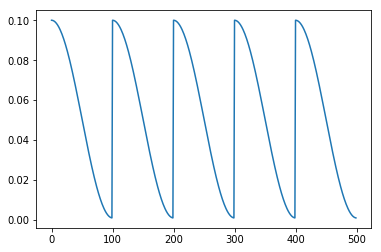

In [105]:
# plot learning rate
plt.plot(ca.lrates)
plt.show()

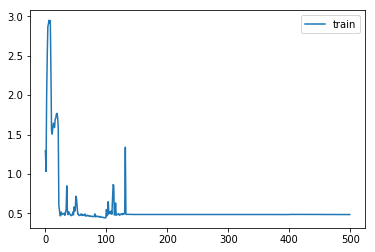

In [106]:
# learning curves of model loss
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

#### Predictions on train data

In [107]:
train_pred = model.predict_classes(X_train)
train_pred_prob = model.predict(X_train)

#### Predictions on test data

In [108]:
test_pred = model.predict_classes(X_test)
test_pred_prob = model.predict(X_test)

##### confusion matrix on train data

In [109]:
confusion_matrix_train = confusion_matrix(y_train, train_pred)
print(confusion_matrix_train)

[[33052     0]
 [ 7678     0]]


#### confusion matrix on test data

In [110]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
print(confusion_matrix_test)

[[14165     0]
 [ 3291     0]]


##### Accuracy, True Negative Rate and True Positive Rate on both train and test data

In [111]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR     : ",TNR_Train)
print("Train TPR     : ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

print('------------------------------------')
Accuracy_Test = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
TPR_Test = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test TNR      : ",TNR_Test)
print("Test TPR      : ",TPR_Test)
print("Test Accuracy : ",Accuracy_Test)

Train TNR     :  1.0
Train TPR     :  0.0
Train Accuracy:  0.8114903019887061
------------------------------------
Test TNR      :  1.0
Test TPR      :  0.0
Test Accuracy :  0.8114688359303391


### MLP Snapshot Ensemble

    Snapshot ensemble requires training a neural network with an aggressive learning rate schedule.

    The cosine annealing schedule is an example of an aggressive learning rate schedule.

In [112]:
# snapshot ensemble with custom learning rate schedule
class SnapshotEnsemble(Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, lrate_min, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lr_min = lrate_min
        self.lrates = list()
 
    # calculate learning rate for epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max, lrate_min):
        epochs_per_cycle = floor(n_epochs/n_cycles)
        cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_min + (lrate_max-lrate_min)/2 * (cos(cos_inner) + 1)
 
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs={}):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max, self.lr_min)
        # set learning rate
        K.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)
 
    # save models at the end of each cycle
    def on_epoch_end(self, epoch, logs={}):
        # check if we can save model
        epochs_per_cycle = floor(self.epochs / self.cycles)
        if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
            # save model to file
            filename = "snapshot_model_%d.h5" % int((epoch + 1) / epochs_per_cycle)
            self.model.save(filename)
            print('>saved snapshot %s, epoch %d' % (filename, epoch))

#### define model

In [113]:
snapshot_model = create_model()

In [114]:
snapshot_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [115]:
# create snapshot ensemble callback
ca = SnapshotEnsemble(N_EPOCHS, N_CYCLES, LR_MAX, LR_MIN)

#### fit model

In [116]:
snapshot_model.fit(X_train, y_train, epochs=N_EPOCHS, callbacks=[ca])

Epoch 1/500
40730/40730 [==============================] - 4s 108us/step - loss: 0.6572 - acc: 0.8097
Epoch 2/500
40730/40730 [==============================] - 3s 83us/step - loss: 1.2583 - acc: 0.8107
Epoch 3/500
40730/40730 [==============================] - 4s 87us/step - loss: 1.7323 - acc: 0.8081
Epoch 4/500
40730/40730 [==============================] - 4s 90us/step - loss: 1.7396 - acc: 0.8115
Epoch 5/500
40730/40730 [==============================] - 4s 91us/step - loss: 1.7403 - acc: 0.8106
Epoch 6/500
40730/40730 [==============================] - 4s 93us/step - loss: 1.7510 - acc: 0.8113
Epoch 7/500
40730/40730 [==============================] - 4s 95us/step - loss: 2.2761 - acc: 0.8041
Epoch 8/500
40730/40730 [==============================] - 4s 96us/step - loss: 2.2872 - acc: 0.8114
Epoch 9/500
40730/40730 [==============================] - 4s 94us/step - loss: 2.2678 - acc: 0.8115
Epoch 10/500
40730/40730 [==============================] - 4s 98us/step - loss: 2.3070 - 

40730/40730 [==============================] - 6s 144us/step - loss: 0.4588 - acc: 0.8115
Epoch 81/500
40730/40730 [==============================] - 6s 145us/step - loss: 0.4566 - acc: 0.8115
Epoch 82/500
40730/40730 [==============================] - 6s 151us/step - loss: 0.4560 - acc: 0.8115
Epoch 83/500
40730/40730 [==============================] - 6s 157us/step - loss: 0.4557 - acc: 0.8114
Epoch 84/500
40730/40730 [==============================] - 6s 150us/step - loss: 0.4572 - acc: 0.8114
Epoch 85/500
40730/40730 [==============================] - 7s 165us/step - loss: 0.4529 - acc: 0.8115
Epoch 86/500
40730/40730 [==============================] - 7s 163us/step - loss: 0.4563 - acc: 0.8115
Epoch 87/500
40730/40730 [==============================] - 7s 177us/step - loss: 0.4580 - acc: 0.8113
Epoch 88/500
40730/40730 [==============================] - 7s 160us/step - loss: 0.4584 - acc: 0.8114
Epoch 89/500
40730/40730 [==============================] - 9s 222us/step - loss: 0.45

40730/40730 [==============================] - 4s 101us/step - loss: 0.5074 - acc: 0.8115
Epoch 159/500
40730/40730 [==============================] - 4s 101us/step - loss: 0.4762 - acc: 0.8115
Epoch 160/500
40730/40730 [==============================] - 4s 101us/step - loss: 0.5329 - acc: 0.8113
Epoch 161/500
40730/40730 [==============================] - 4s 101us/step - loss: 0.4972 - acc: 0.8114
Epoch 162/500
40730/40730 [==============================] - 4s 109us/step - loss: 0.4899 - acc: 0.8115
Epoch 163/500
40730/40730 [==============================] - 4s 109us/step - loss: 0.5294 - acc: 0.8115
Epoch 164/500
40730/40730 [==============================] - 5s 111us/step - loss: 0.4921 - acc: 0.8115 1s - loss:
Epoch 165/500
40730/40730 [==============================] - 4s 107us/step - loss: 0.4723 - acc: 0.8114
Epoch 166/500
40730/40730 [==============================] - 4s 103us/step - loss: 0.4812 - acc: 0.8114
Epoch 167/500
40730/40730 [==============================] - 4s 107

40730/40730 [==============================] - 4s 100us/step - loss: 0.4858 - acc: 0.8115
Epoch 237/500
40730/40730 [==============================] - 4s 103us/step - loss: 0.4854 - acc: 0.8115
Epoch 238/500
40730/40730 [==============================] - 4s 106us/step - loss: 0.4849 - acc: 0.8115
Epoch 239/500
40730/40730 [==============================] - 4s 102us/step - loss: 0.4851 - acc: 0.8115
Epoch 240/500
40730/40730 [==============================] - 4s 106us/step - loss: 0.4852 - acc: 0.8115
Epoch 241/500
40730/40730 [==============================] - 4s 104us/step - loss: 0.4852 - acc: 0.8115
Epoch 242/500
40730/40730 [==============================] - 4s 103us/step - loss: 0.4851 - acc: 0.8115
Epoch 243/500
40730/40730 [==============================] - 4s 100us/step - loss: 0.4854 - acc: 0.8115
Epoch 244/500
40730/40730 [==============================] - 4s 102us/step - loss: 0.4850 - acc: 0.8115
Epoch 245/500
40730/40730 [==============================] - 4s 101us/step - l

40730/40730 [==============================] - 4s 108us/step - loss: 0.4855 - acc: 0.8115
Epoch 315/500
40730/40730 [==============================] - 5s 134us/step - loss: 0.4859 - acc: 0.8115
Epoch 316/500
40730/40730 [==============================] - 5s 125us/step - loss: 0.4855 - acc: 0.8115
Epoch 317/500
40730/40730 [==============================] - 5s 134us/step - loss: 0.4853 - acc: 0.8115
Epoch 318/500
40730/40730 [==============================] - 5s 116us/step - loss: 0.4853 - acc: 0.8115
Epoch 319/500
40730/40730 [==============================] - 5s 115us/step - loss: 0.4857 - acc: 0.8115
Epoch 320/500
40730/40730 [==============================] - 4s 108us/step - loss: 0.4853 - acc: 0.8115
Epoch 321/500
40730/40730 [==============================] - 4s 109us/step - loss: 0.4853 - acc: 0.8115
Epoch 322/500
40730/40730 [==============================] - 4s 108us/step - loss: 0.4858 - acc: 0.8115
Epoch 323/500
40730/40730 [==============================] - 4s 105us/step - l

40730/40730 [==============================] - 7s 167us/step - loss: 0.4841 - acc: 0.8115
Epoch 393/500
40730/40730 [==============================] - 7s 162us/step - loss: 0.4841 - acc: 0.8115
Epoch 394/500
40730/40730 [==============================] - 7s 167us/step - loss: 0.4841 - acc: 0.8115
Epoch 395/500
40730/40730 [==============================] - 7s 171us/step - loss: 0.4841 - acc: 0.8115
Epoch 396/500
40730/40730 [==============================] - 7s 182us/step - loss: 0.4841 - acc: 0.8115
Epoch 397/500
40730/40730 [==============================] - 7s 184us/step - loss: 0.4841 - acc: 0.8115
Epoch 398/500
40730/40730 [==============================] - 8s 197us/step - loss: 0.4841 - acc: 0.8115
Epoch 399/500
40730/40730 [==============================] - 8s 199us/step - loss: 0.4841 - acc: 0.8115
Epoch 400/500
40730/40730 [==============================] - 8s 192us/step - loss: 0.4841 - acc: 0.8115
>saved snapshot snapshot_model_4.h5, epoch 399
Epoch 401/500
40730/40730 [====

40730/40730 [==============================] - 5s 133us/step - loss: 0.4844 - acc: 0.8115
Epoch 471/500
40730/40730 [==============================] - 5s 127us/step - loss: 0.4845 - acc: 0.8115
Epoch 472/500
40730/40730 [==============================] - 5s 122us/step - loss: 0.4844 - acc: 0.8115
Epoch 473/500
40730/40730 [==============================] - 6s 145us/step - loss: 0.4845 - acc: 0.8115
Epoch 474/500
40730/40730 [==============================] - 7s 165us/step - loss: 0.4843 - acc: 0.8115
Epoch 475/500
40730/40730 [==============================] - 6s 139us/step - loss: 0.4843 - acc: 0.8115
Epoch 476/500
40730/40730 [==============================] - 5s 123us/step - loss: 0.4843 - acc: 0.8115
Epoch 477/500
40730/40730 [==============================] - 6s 146us/step - loss: 0.4844 - acc: 0.8115
Epoch 478/500
40730/40730 [==============================] - 7s 168us/step - loss: 0.4844 - acc: 0.8115
Epoch 479/500
40730/40730 [==============================] - 6s 152us/step - l

#### Load Models

In [117]:
# load models from file
def load_save_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'snapshot_model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [118]:
# load models in order
members = load_save_models(3)

>loaded snapshot_model_1.h5
>loaded snapshot_model_2.h5
>loaded snapshot_model_3.h5


#### Prediction on the Train dataset

In [119]:
y_pred = [model.predict(X_train).flatten() for model in members]

In [120]:
y_pred = np.array(y_pred)

In [121]:
y_pred.shape

(3, 40730)

In [122]:
y_pred = y_pred.T

#### Stacked Models on Train dataset 

Building the 2nd level model with lables as input attributes.

In [123]:
stacked_model1 = Sequential()
stacked_model1.add(Dense(1, input_dim=3, activation='sigmoid'))

In [124]:
stacked_model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [125]:
stacked_model1.fit(y_pred, y_train, epochs=100)

Epoch 1/100
40730/40730 [==============================] - 4s 91us/step - loss: 0.5582 - acc: 0.8115
Epoch 2/100
40730/40730 [==============================] - 3s 80us/step - loss: 0.4746 - acc: 0.8115
Epoch 3/100
40730/40730 [==============================] - 4s 88us/step - loss: 0.4387 - acc: 0.8115
Epoch 4/100
40730/40730 [==============================] - 4s 90us/step - loss: 0.4168 - acc: 0.8115
Epoch 5/100
40730/40730 [==============================] - 4s 94us/step - loss: 0.4026 - acc: 0.8115
Epoch 6/100
40730/40730 [==============================] - 4s 94us/step - loss: 0.3932 - acc: 0.8115
Epoch 7/100
40730/40730 [==============================] - 4s 95us/step - loss: 0.3868 - acc: 0.8115
Epoch 8/100
40730/40730 [==============================] - 4s 101us/step - loss: 0.3823 - acc: 0.8115
Epoch 9/100
40730/40730 [==============================] - 3s 86us/step - loss: 0.3791 - acc: 0.8115
Epoch 10/100
40730/40730 [==============================] - 3s 82us/step - loss: 0.3768 - 

40730/40730 [==============================] - 5s 129us/step - loss: 0.3668 - acc: 0.8115
Epoch 82/100
40730/40730 [==============================] - 5s 117us/step - loss: 0.3668 - acc: 0.8115
Epoch 83/100
40730/40730 [==============================] - 5s 122us/step - loss: 0.3668 - acc: 0.8115
Epoch 84/100
40730/40730 [==============================] - 5s 123us/step - loss: 0.3668 - acc: 0.8115
Epoch 85/100
40730/40730 [==============================] - 5s 117us/step - loss: 0.3668 - acc: 0.8115
Epoch 86/100
40730/40730 [==============================] - 5s 120us/step - loss: 0.3668 - acc: 0.8115
Epoch 87/100
40730/40730 [==============================] - 5s 114us/step - loss: 0.3668 - acc: 0.8115
Epoch 88/100
40730/40730 [==============================] - 5s 126us/step - loss: 0.3668 - acc: 0.8115
Epoch 89/100
40730/40730 [==============================] - 5s 125us/step - loss: 0.3668 - acc: 0.8115
Epoch 90/100
40730/40730 [==============================] - 4s 105us/step - loss: 0.36

In [126]:
stacked_model1_pred = stacked_model1.predict_classes(y_pred)

#### Getting evaluation metrics and evaluating model performance

In [127]:
confusion_matrix_train = confusion_matrix(y_train, stacked_model1_pred)
print(confusion_matrix_train)

[[33052     0]
 [ 7678     0]]


#### Prediction on the Test dataset

In [128]:
# make predictions
y_pred = [model.predict(X_test).flatten() for model in members]

In [129]:
y_pred = np.array(y_pred)

In [130]:
y_pred.shape

(3, 17456)

In [131]:
y_pred = y_pred.T

#### Predictions on Stacked Models with Test dataset 

In [132]:
stacked_model1_pred = stacked_model1.predict_classes(y_pred)

#### Getting evaluation metrics and evaluating model performance

In [133]:
confusion_matrix_test = confusion_matrix(y_test, stacked_model1_pred)
print(confusion_matrix_test)

[[14165     0]
 [ 3291     0]]


#### Accuracy, True Positive Rate and True Negative Rates on train and test dataset

In [134]:
Accuracy_Train_stacked_model1 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_stacked_model1 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_stacked_model1 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR     : ", TNR_Train_stacked_model1)
print("Train TPR     : ", TPR_Train_stacked_model1)
print("Train Accuracy: ", Accuracy_Train_stacked_model1)

print("----------------------------------")

Accuracy_Test_stacked_model1 =(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_stacked_model1 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
TPR_Test_stacked_model1 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])

print("Test TNR      : ",TNR_Test_stacked_model1)
print("Test TPR      : ",TPR_Test_stacked_model1)
print("Test Accuracy : ",Accuracy_Test_stacked_model1)

Train TNR     :  1.0
Train TPR     :  0.0
Train Accuracy:  0.8114903019887061
----------------------------------
Test TNR      :  1.0
Test TPR      :  0.0
Test Accuracy :  0.8114688359303391


### Reference Links:

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

https://keras.io/